In [1]:
import random
import re
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from operator import itemgetter
import sys
from mnist import MNIST
mnist_data = MNIST('./MNIST_DATA')

In [30]:
# Задаем основные параметры для ГА
generations = 50
population_size = 50
chromosome_bodyoncetoldme = 784 # длина хромосомы
selection_count = 25 # сколько особей выбирается в селекции
mutation_normal = 0.05 # шанс мутации, от 0 до 1

In [31]:
images_train, labels_train = mnist_data.load_training()
learning_data = mnist_data.process_images_to_numpy(images_train)
correct_answers = mnist_data.process_labels(labels_train)

In [32]:
train_filter = []
for element in correct_answers:
  if (element == 0) | (element == 1):
    train_filter.append(True)
  else:
    train_filter.append(False)

# Нейроны
x = np.around(learning_data / 255)[train_filter]
y = np.array(correct_answers)[train_filter]

print(y)

[0 1 1 ... 1 0 1]


In [33]:
# Функция активации
def activate_function(current_value):
    if(current_value > 0):
        return 1
    else:
        return 0

make_answer = np.vectorize(activate_function)

In [34]:
def generate_population(size):

    result = []

    for num in range(size):
        w = []
        for i in range(chromosome_bodyoncetoldme):
            w.append(random.uniform(-1, 1))
        result.append(w)
    return result

In [35]:
def predict(vector):
    result = 0
    for i in range(2):
        if(vector == 1): 
            result = i
    return result

# Функция приспособленности
def fitness_function(w):
    # w=np.array(w).reshape(len(w),1)
    y_1 = x@w
    y_1 = make_answer(y_1)

    right = 0

    for i in range(len(x)):
        if(predict(y_1[i]) == y[i]):
            right += 1

    total_items = len(x)

    accyracy = right / total_items
    # Доля правильных ответов
    return accyracy

data_set = generate_population(1)[0]
fitness_function(data_set)

0.8727200947493091

In [36]:
def print_population(data):
    data_frame = pd.DataFrame(data)
    print(data_frame)

def population_best_result(data):
    temp_data = []
    for item in data:
        temp_data.append((fitness_function(item), item))

    best_result = sorted(temp_data, key=itemgetter(0), reverse=True)[0]

    return (best_result)

def population_max_result(data):
    temp_data = []
    for item in data:
        temp_data.append((fitness_function(item), item))

    max_result = sorted(temp_data, key=itemgetter(0))[0]

    return (max_result)

def population_average_result(data):
    temp_data = []
    for item in data:
        temp_data.append((fitness_function(item)))

    avg_result = np.mean(temp_data)

    return avg_result

In [37]:
def roulette_selection(data, sel_count):
    pool = []
    sectors = []
    wheel = []
    f_sum = 0

    for chromosome in data:
        f = fitness_function(chromosome)
        f_sum += f
    for chromosome in data:
        f = fitness_function(chromosome)
        v = f / f_sum * 100
        sectors.append((v, chromosome))

    point = 0

    for i in range(0, len(sectors) - 1):
        wheel.append((sectors[i][1], (point, point + sectors[i][0])))
        point += sectors[i][0]
        if(i == len(sectors) - 2):
            wheel.append((sectors[i][1], (point, 100)))
    for i in range(sel_count):
        choice = random.randint(0, 100)
        for j in wheel:
            if((choice >= j[1][0]) and (choice <= j[1][1])):
                pool.append(j[0])
                break

    return pool

In [38]:
def simple_selection(data, sel_count):
    pool = []
    adaptation = []
    for chromosome in data:
        adaptation.append((fitness_function(chromosome), chromosome))

    adaptation = sorted(adaptation, key=itemgetter(0), reverse=True)

    for i in range(0, sel_count):
        pool.append(adaptation[i][1])

    return pool

In [39]:
def permutation_crossover(parent_1, parent_2, chromo_length):
    chromo_length -= 2
    par_1_start = parent_1[0]
    par_2_start = parent_2[0]
    par_1_end = parent_1[len(parent_1) - 1]
    par_2_end = parent_2[len(parent_1) - 1]
    parent_1 = parent_1[1:len(parent_1) - 1]
    parent_2 = parent_2[1:len(parent_2) - 1]

    pos_1 = random.randint(1, chromo_length // 2 - 1)
    pos_2 = random.randint(pos_1 + 1, chromo_length - 1)
    middle = parent_1[pos_1:pos_2 + 1]

    temp_data = []

    for i in parent_2:
        if not (i in middle): temp_data.append(i)

    child_1 = []

    for i in range(0, chromo_length - 1):
        if(i < pos_1): child_1.append(temp_data.pop(0))
        elif(i == pos_1): child_1 += middle
        elif(i == pos_2): child_1.append(temp_data.pop(0))
        elif(i > pos_2) and (len(temp_data) > 0): child_1.append(temp_data.pop(0))
        elif(i > pos_2) and (len(temp_data) == 0): child_1.append(parent_2[i])

    middle = parent_2[pos_1:pos_2 + 1]
    temp_data = []

    for i in parent_1:
        if not (i in middle): temp_data.append(i)

    child_2 = []

    for i in range(0, chromo_length - 1):
        if(i < pos_1): child_2.append(temp_data.pop(0))
        elif(i == pos_1): child_2 += middle
        elif(i == pos_2): child_2.append(temp_data.pop(0))
        elif(i > pos_2) and (len(temp_data) > 0): child_2.append(temp_data.pop(0))
        elif(i > pos_2) and (len(temp_data) == 0): child_2.append(parent_1[i])

    child_1.insert(0, par_1_start)
    child_1.append(par_1_end)

    child_2.insert(0, par_2_start)
    child_2.append(par_2_end)

    return child_1, child_2

In [40]:
def two_point_crossover(parent_1, parent_2, chromo_length):
    chromo_length -= 2

    par_1_start = parent_1[0]
    par_2_start = parent_2[0]
    par_1_end = parent_1[len(parent_1) - 1]
    par_2_end = parent_2[len(parent_1) - 1]
    parent_1 = parent_1[1:len(parent_1) - 1]
    parent_2 = parent_2[1:len(parent_2) - 1]

    pos_1 = random.randint(1, chromo_length // 2 - 1)
    pos_2 = random.randint(pos_1 + 1, chromo_length - 1)

    child_1 = parent_1[0:pos_1] + parent_2[pos_1 - 1:pos_2] + parent_1[pos_2 + 1:chromo_length]
    child_2 = parent_2[0:pos_1] + parent_1[pos_1 - 1:pos_2] + parent_2[pos_2 + 1:chromo_length]

    child_1.insert(0, par_1_start)
    child_1.append(par_1_end)
    child_2.insert(0, par_2_start)
    child_2.append(par_2_end)

    return child_1, child_2

In [41]:
def mutation(chromosome, chrom_length):
    result = chromosome
    choice = random.random()

    if(choice - mutation_normal <= 0):
        pos_1 = random.randint(0, chrom_length // 2 - 1)
        pos_2 = random.randint(pos_1 + 1, chrom_length - 1)

        temp_data = result[pos_1:pos_2 + 1]

        for i in range(len(temp_data)):
            temp_data[i] = random.random()

        result[pos_1:pos_2 + 1] = temp_data

    return result

In [46]:
average_results = []
max_results = []
min_results = []
best = []

elite_size = 10

current_population = generate_population(population_size)

for generation in range(generations):
    if(elite_size > 0):
        elite = simple_selection(current_population, elite_size)

    current_population = roulette_selection(current_population, selection_count)

    for i in range((population_size - selection_count - elite_size) // 2):
        parent_1 = random.randint(0, selection_count - 1)
        parent_2 = random.randint(0, selection_count - 1)

        while(parent_2 == parent_1): 
            parent_2 = random.randint(0, selection_count - 1)

        childrens = permutation_crossover(current_population[parent_1], current_population[parent_2], chromosome_bodyoncetoldme)

        current_population.append(childrens[0])
        current_population.append(childrens[1])

    temp_data = current_population
    for count in range(0, len(current_population) - 1):
        temp_data[count] = mutation(current_population[count], chromosome_bodyoncetoldme)

    current_population = temp_data

    if(elite_size > 0):
        current_population += elite

    if(len(current_population) < population_size):
        current_population.append(generate_population(1)[0])

    best_result = population_best_result(current_population)

    min_results.append(best_result[0])
    max_results.append(population_max_result(current_population)[0])
    average_results.append(population_average_result(current_population))

    print(f'Текущая итерация: {generation}')
print(f"Лучший результат в конце {generations} поколения:")
print(min_results[generations - 1], best_result[1])

Текущая итерация: 0
Текущая итерация: 1
Текущая итерация: 2
Текущая итерация: 3
Текущая итерация: 4
Текущая итерация: 5
Текущая итерация: 6
Текущая итерация: 7
Текущая итерация: 8
Текущая итерация: 9
Текущая итерация: 10
Текущая итерация: 11
Текущая итерация: 12
Текущая итерация: 13
Текущая итерация: 14
Текущая итерация: 15
Текущая итерация: 16
Текущая итерация: 17
Текущая итерация: 18
Текущая итерация: 19
Текущая итерация: 20
Текущая итерация: 21
Текущая итерация: 22
Текущая итерация: 23
Текущая итерация: 24
Текущая итерация: 25
Текущая итерация: 26
Текущая итерация: 27
Текущая итерация: 28
Текущая итерация: 29
Текущая итерация: 30
Текущая итерация: 31
Текущая итерация: 32
Текущая итерация: 33
Текущая итерация: 34
Текущая итерация: 35
Текущая итерация: 36
Текущая итерация: 37
Текущая итерация: 38
Текущая итерация: 39
Текущая итерация: 40
Текущая итерация: 41
Текущая итерация: 42
Текущая итерация: 43
Текущая итерация: 44
Текущая итерация: 45
Текущая итерация: 46
Текущая итерация: 47
Те

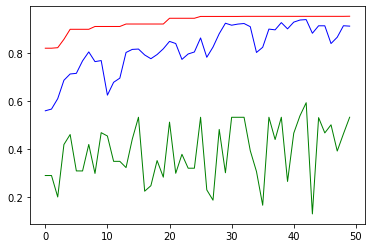

In [47]:
# график приспособленности по поколениям
def draw_progress(average_results, max_results, min_results, pok_count):
    x = range(pok_count)
    y_1 = average_results
    y_2 = max_results
    y_3 = min_results
    plt.plot(x, y_1, linewidth=1, color="blue")
    plt.plot(x, y_2, linewidth=1, color="green" )
    plt.plot(x, y_3, linewidth=1, color="red")
    plt.show()

draw_progress(average_results, max_results, min_results, generations)